In [1]:
import pandas as pd
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import patches

In [2]:
dataset_root = '/mnt/storage/datasets/vinbigdata'
train = pd.read_csv(Path(dataset_root + '/train.csv'))
test = pd.read_csv(Path(dataset_root + '/test.csv'))
train_pics_names = list(Path(dataset_root + '/train').glob('*.jpg'))

In [3]:
train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [4]:
train.dtypes

image_id       object
class_name     object
class_id        int64
rad_id         object
x_min         float64
y_min         float64
x_max         float64
y_max         float64
width           int64
height          int64
dtype: object

In [5]:
n_pics = 8  # Number of x-rays to display

images_sample = []
images_ids = train.image_id.value_counts().index
ids_of_interest = images_ids[:n_pics]
# ids_of_interest = train.image_id.value_counts().index[-n_pics:][::-1]
for image_id in ids_of_interest:
        pil_image = Image.open(dataset_root+'/train/'+image_id+'.jpg')
        # pil_image.resize((1024, 1024))
        image = np.array(pil_image)
        images_sample.append(image)


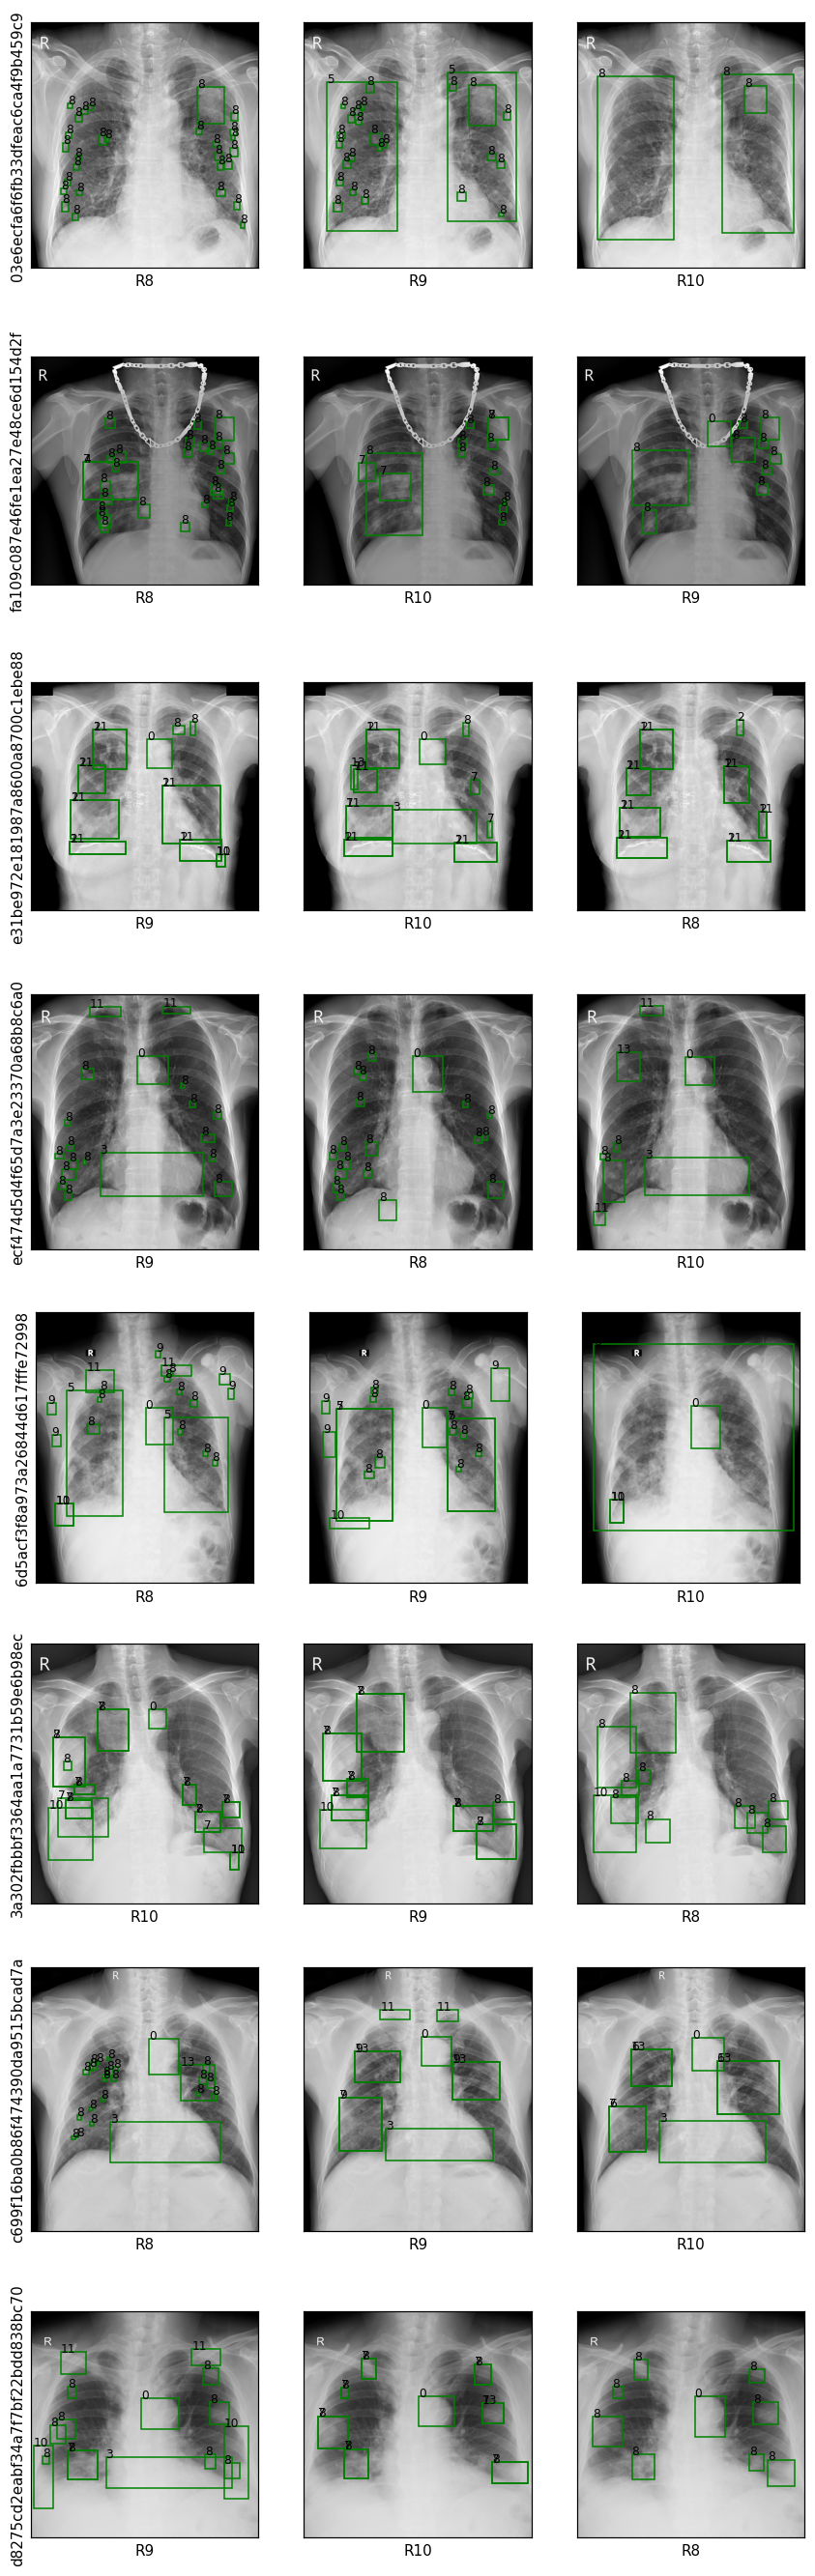

In [6]:
fig, axs = plt.subplots(n_pics,3, figsize=(9.45,4*n_pics), dpi=109.28)
for row in range(n_pics):
    # Find all the samples related to the current x-ray
    entries = train.loc[train['image_id']==ids_of_interest[row]]
    # Find which radiologists have provided ground truth for the current x-ray
    rads = entries['rad_id'].value_counts().index
    assert(len(rads)<=3)  # They are supposed to be no more than 3
    for col in range(len(rads)):  # One column per radiologist who provided ground truth
        axs[row, col].imshow(images_sample[row], cmap='gray')
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])
        if col == 0:
            axs[row, col].set_ylabel(ids_of_interest[row])
        axs[row, col].set_xlabel(rads[col])
        # Find all the samples related to the current x-ray and radiologist
        entries_rad = entries.loc[entries['rad_id']==rads[col]]
        # Overlay ground truth provided by radiologist
        for _, entry in entries_rad.iterrows():
            x_min, x_max = entry['x_min'], entry['x_max']
            y_min, y_max = entry['y_min'], entry['y_max']
            rect = patches.Rectangle((x_min,y_min),
                                     x_max-x_min,
                                     y_max-y_min,
                                     linewidth=1,edgecolor='g',
                                     facecolor='none')
            axs[row, col].add_patch(rect)
            axs[row, col].text(x_min, y_min, entry['class_id'], fontsize=8)

In [7]:
grouped = train.groupby(['image_id', 'class_id'])['rad_id'].value_counts()
# images_ids = train.image_id.value_counts().index
n_samples = len(images_ids)
diagnosis = np.zeros((n_samples, 15), dtype =int)
for ((image_id, class_id, rad_id), _) in grouped.iteritems():
    diagnosis[images_ids.get_loc(image_id), class_id] += 1
diagnosis = (diagnosis >= 2).astype(int)

In [8]:
# Sanity check
count =0
for line in diagnosis:
    # sum(line[:14]) > 0 => line[-1]==0
    assert(sum(line[:14]) == 0 or  line[-1]==0)
    assert((line[-1]==0 and sum(line[:14])>=0) or (line[-1]==1 and sum(line[:14])==0))
    count +=1

In [9]:
count_by_diagnosis = diagnosis.sum(axis=0)

<BarContainer object of 15 artists>

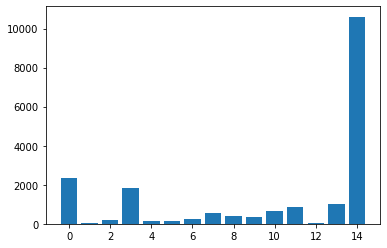

In [10]:
plt.bar(range(len(count_by_diagnosis)), count_by_diagnosis)

<BarContainer object of 14 artists>

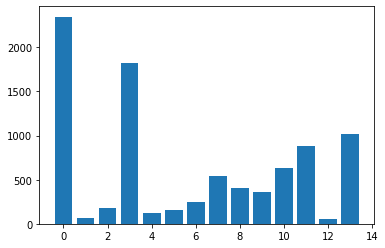

In [11]:
plt.bar(range(len(count_by_diagnosis[:14])), count_by_diagnosis[:14])

In [12]:
# Shuffle the dataset
dataset = pd.DataFrame(diagnosis)

In [13]:
dataset['image_id'] = images_ids

In [14]:
dataset = dataset.sample(frac=1)

In [15]:
len(dataset)

15000